In [1]:
# import os and change directory
import os
os.chdir('/content/drive/My Drive/CS5000/Faster_RCNN_for_Open_Images_Dataset_Keras/')
!ls

Archive		      frcnn_train_vgg.ipynb			README.md
data_prep.ipynb       model
frcnn_test_vgg.ipynb  Object_Detection_DataPreprocessing.ipynb


In [2]:
import glob
import random
import shutil 
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import xml.etree.ElementTree as ET

In [3]:
# path to source data
sourceData = '/content/drive/My Drive/CS5000/pet_object_detection/'
print(f'found {len(os.listdir(sourceData))//2} images')

found 3 images


In [5]:
# perform train/test split
# 1. change directory to sourceData
os.chdir(sourceData)
# 2. check if test/train folders exists, if not create them
if os.path.isdir('train') is False:
  os.makedirs('train')
  os.makedirs('test')
  os.makedirs('valid')
  print('3 folders created!')
else:
  print('folders already exists!')

folders already exists!


In [ ]:
# move images to corresponding folders
n_train = 110
n_valid = 20
n_test = 12

assert (n_train+n_test+n_valid)==(len(os.listdir(sourceData))-3)/2

In [ ]:
# move training images and xml to train
for c in random.sample(glob.glob('*.png'), n_train):
  # image = c
  label = c.split('.')[0]+'.xml'
  shutil.move(c, 'train/')
  shutil.move(label, 'train/')
# move validation images and xml to valid
for c in random.sample(glob.glob('*.png'), n_valid):
  # image = c
  label = c.split('.')[0]+'.xml'
  shutil.move(c, 'valid/')
  shutil.move(label, 'valid/')
for c in random.sample(glob.glob('*.png'), n_test):
  # image = c
  label = c.split('.')[0]+'.xml'
  shutil.move(c, 'test/')
  shutil.move(label, 'test/')


In [ ]:
assert len(os.listdir('train'))/2 == n_train
assert len(os.listdir('valid'))/2 == n_valid
assert len(os.listdir('test'))/2 == n_test

In [7]:
# check that images were moved correctly
train_imgs = os.listdir('train')
valid_imgs = os.listdir('valid')
test_imgs = os.listdir('test')
print(f'found {len(train_imgs)//2} images in train')
print(f'found {len(valid_imgs)//2} images in valid')
print(f'found {len(test_imgs)//2} images in test')

found 110 images in train
found 20 images in valid
found 12 images in test


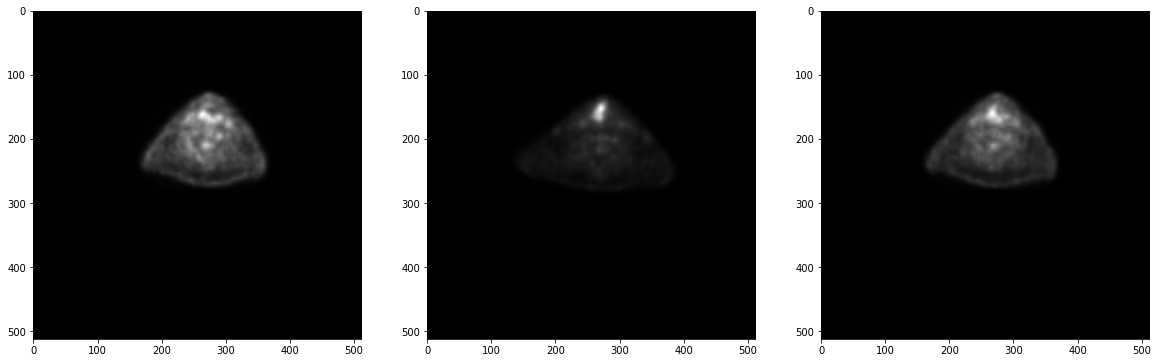

In [8]:
# show a sample image from each folder
tr = cv2.imread(f'train/{train_imgs[0]}', 0)
va = cv2.imread(f'valid/{valid_imgs[0]}', 0)
ts = cv2.imread(f'test/{test_imgs[0]}', 0)

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,10))
ax[0].imshow(tr, cmap='gray')
ax[1].imshow(va, cmap='gray')
ax[2].imshow(ts, cmap='gray')

In [ ]:
# convert xml to csv
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [ ]:
for folder in ['train', 'valid', 'test']:
  image_path = os.path.join(os.getcwd(), folder)
  xml_df = xml_to_csv(image_path)
  xml_df.to_csv(os.path.join(os.getcwd(),folder+'_labels.csv'), index=None)
  print('Successfully converted xml to csv.')

Successfully converted xml to csv.
Successfully converted xml to csv.
Successfully converted xml to csv.


In [9]:
# view sample images
train_df = pd.read_csv('train_labels.csv')
valid_df = pd.read_csv('valid_labels.csv')
test_df = pd.read_csv('test_labels.csv')

In [10]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,HN-HGJ-001-32.png,512,512,tumor,255,134,287,182
1,HN-HGJ-001-35.png,512,512,tumor,253,147,282,179
2,HN-HGJ-001-36.png,512,512,tumor,250,148,279,181
3,HN-HGJ-002-49.png,512,512,tumor,230,127,270,169
4,HN-HGJ-002-50.png,512,512,tumor,230,125,268,168


In [11]:
x_train_min = train_df['xmin'].iloc[0]
y_train_min = train_df['ymin'].iloc[0]
x_train_max = train_df['xmax'].iloc[0]
y_train_max = train_df['ymax'].iloc[0]

x_valid_min = valid_df['xmin'].iloc[0]
y_valid_min = valid_df['ymin'].iloc[0]
x_valid_max = valid_df['xmax'].iloc[0]
y_valid_max = valid_df['ymax'].iloc[0]

x_test_min = test_df['xmin'].iloc[0]
y_test_min = test_df['ymin'].iloc[0]
x_test_max = test_df['xmax'].iloc[0]
y_test_max = test_df['ymax'].iloc[0]

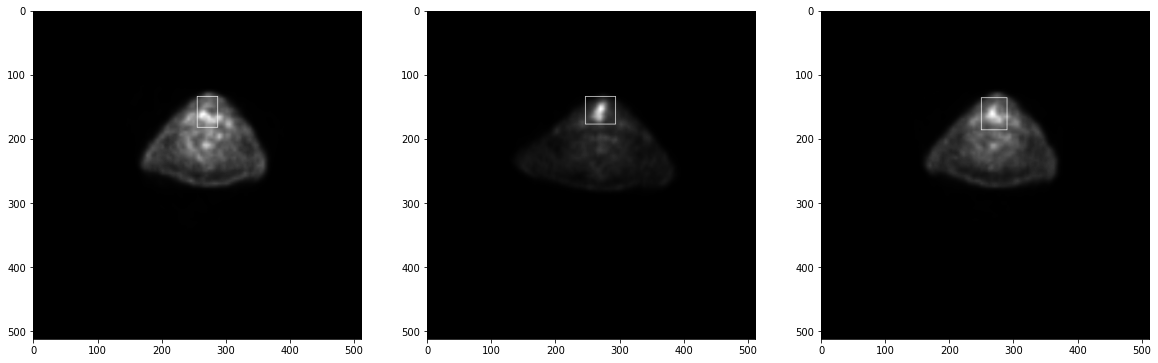

In [12]:
tr = cv2.rectangle(tr, (x_train_min, y_train_min), (x_train_max, y_train_max), color=(255,0,0), thickness=1)
va = cv2.rectangle(va, (x_valid_min, y_valid_min), (x_valid_max, y_valid_max), color=(255,0,0), thickness=1)
ts = cv2.rectangle(ts, (x_test_min, y_test_min), (x_test_max, y_test_max), color=(255,0,0), thickness=1)

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,10))
ax[0].imshow(tr, cmap='gray')
ax[1].imshow(va, cmap='gray')
ax[2].imshow(ts, cmap='gray')


In [43]:
# convert xml to annotate.txt
def annotate(df, name):
  data = pd.DataFrame()
  data['format'] = df['filename']

  # as the images are in train_images folder, add train_images before the image name
  for i in range(data.shape[0]):
    data['format'][i] = f'{name}/' + data['format'][i]

  # add xmin, ymin, xmax, ymax and class as per the format required
  for i in range(data.shape[0]):
    data['format'][i] = data['format'][i] + ',' + str(df['xmin'][i]) + ',' + str(df['ymin'][i]) + ',' + str(df['xmax'][i]) + ',' + str(df['ymax'][i]) + ',' + df['class'][i]

  data.to_csv(f'{name}_annotate.txt', header=None, index=None, sep=' ')
  print(f'{name} annotation file saved successully!')
  return data
  

In [44]:
trainAnnotate = annotate(train_df,'train')
validAnnotate = annotate(valid_df,'valid')
testAnnotate = annotate(test_df,'test')

train annotation file saved successully!
valid annotation file saved successully!
test annotation file saved successully!


In [45]:
!ls

test		   train	       valid
test_annotate.txt  train_annotate.txt  valid_annotate.txt
test_labels.csv    train_labels.csv    valid_labels.csv
